# Dataset Description
There are some proteins that interact with DNA and controls many characteristics of the DNA. The impact is so powerful that it even affects drug design at industry level. Our goal in this project is to devise a computational method that is able to distinguish DNA binding proteins (positive class) from normal proteins (negative class). There are protein structure based laboratory methods for this, but they are time consuming, expensive and worst of all not even accurate. What we want to do is: design a machine learning based approach to do this task given the protein sequences in a cheap and easy way. You do not need any biology knowledge to work on this problem. But if you want to explore protein biology and relevant feature extraction tools, you are most welcome to do so. 

# Dataset Details
- Two files - (1) Train.fasta and (2) Test.fasta
- Each sequence consists of a combination of 20 unique characters (each character represents one unique amino acid)
    - Example: "MLTPRDENNEGDAMPMLKKPRYSSLSGQSTNITYQEHTISREERAAAVGRHEGFRGCTIWFTGLSGAGKTTISFALERTLNKLGIPCYGLDGDNIRHGLCKNLGFSKEDRQENIRRVAEVAKLFADSGMICLAAFISPFQEDRLDARKIHESENVKFIEVHVSTTLEVCEQRDPKPSELYKKARAGQILGFTGIDSAYEPPENAEIILDAGKDGVQQCVQKVLDHLESKGLLPEQIPDVPAVRELFVSDDLTVAELLKESQNLPTVELTKVDLQWLQVLAEGWATPLSGFMRERQYLQSMHFGQLLDLKHKVAFVGEKSDDKEDSWPMMDDINQSIPIVLPISDDVKKGLEGVTRIALKYNGQVYAILSDPEIFEHRKDERVCRQFGTNDPRHPAVAQVLESGNWLLGGDVAVVQKIQFNDGLDKYRKTPNELRAIFAEKNADAVFAFQLRNPIHNGHALLMRDTREKLLAEHKNPILLLHPLGGWTKDDDVPLDIRIKQHEAVIAERVLDPEWTVLSIFPSPMMYAGPTEVQWHARSRIAAGIQHYIVGRDPAGIQKPGSPDALYETTHGAKVLSMAPGLSALHILPFRVAAYDKTAKKMSFFDTSRKEDFENISGTKMRGLARNGDTPPEGFMAPTAWEVLAGYYKSLQNSN"
- The class label is provided in the header of each protein sequence in the fasta files as "label_1" and "label_0" for positive and negative sequences, respectively
    - Example: 
    ">seq_17848_label_1" (positive sequence)
    ">seq_17860_label_0" (negative sequence)
- A lot more negative sequences compared to positive sequences in both train and test set
- The protein sequences are of variable length (50 to 3000 characters)

# Expected Task Description
- You need to train and tune your model using Train.fasta
- Finally, you need to test on the Test.fasta
- As test performance metric, you need use sensitivity, specificity and MCC score
- Remember to explore:
    - character level language models
    - various feature extraction techniques
    - class balancing methods during training

# Read fasta files using Biopython

In [1]:
#pip install biopython
#pip install kat

In [2]:
from Bio import SeqIO
from Bio.Seq import Seq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
training = 'Data/Train.fasta'
tr_records = SeqIO.parse(training, 'fasta')
tr_data = []
for record in tr_records:
    # Extract the sequence ID (before "_label") and the label (after "_label")
    parts = record.id.split('_')
    seq_id = '_'.join(parts[:-2])  # Join the parts of ID before "_label"
    label = parts[-1]  # The label is the last part after "_label"
    
    tr_data.append({"ID": seq_id, "Label": label, "sequence": str(record.seq)})
df_training = pd.DataFrame(tr_data)
df_training['Label'] = df_training['Label'].astype(int)
df_training.head()

,ID,Label,sequence
0,seq_0,1,MANILNLKHLLTLALILLALATKSSTSSSSSITRVKGIYWLENPFF...
1,seq_1,1,MVALLLFPMLLQLLSPTCAQTQKNITLGSTLAPQGPASSWLSPSGD...
2,seq_2,1,MDILQLAPTHLLAILLSSTSALFLITYLLRAGHRPSDLPNGPPTVP...
3,seq_3,1,MRLHQSPPRLLVCILSVLQVSAGLSSNCRCMPGDSCWPSLNDWARF...
4,seq_4,1,MAKIDVHHHFYPPAMRQALDRAGGDPSGWYIPPWTLELDQDITRQM...


In [5]:
testing = 'DNA Binding Protein/Train.fasta'
t_records = SeqIO.parse(training, 'fasta')
t_data = []
for record in t_records:
    # Extract the sequence ID (before "_label") and the label (after "_label")
    parts = record.id.split('_')
    seq_id = '_'.join(parts[:-2])  # Join the parts of ID before "_label"
    label = parts[-1]  # The label is the last part after "_label"
    
    t_data.append({"ID": seq_id, "Label": label, "sequence": str(record.seq)})
df_testing = pd.DataFrame(t_data)
df_testing['Label'] = df_training['Label'].astype(int)
df_testing.head()

,ID,Label,sequence
0,seq_0,1,MANILNLKHLLTLALILLALATKSSTSSSSSITRVKGIYWLENPFF...
1,seq_1,1,MVALLLFPMLLQLLSPTCAQTQKNITLGSTLAPQGPASSWLSPSGD...
2,seq_2,1,MDILQLAPTHLLAILLSSTSALFLITYLLRAGHRPSDLPNGPPTVP...
3,seq_3,1,MRLHQSPPRLLVCILSVLQVSAGLSSNCRCMPGDSCWPSLNDWARF...
4,seq_4,1,MAKIDVHHHFYPPAMRQALDRAGGDPSGWYIPPWTLELDQDITRQM...


Each protein sequence given here consists of amino acids (each character is a representation of one amino acid)
![20 amino acids that make up protein](https://i0.wp.com/www.compoundchem.com/wp-content/uploads/2014/09/20-Common-Amino-Acids.png?fit=2480%2C1754&ssl=1)

In [6]:
standard_amino_acids = 'ARNDCEQGHILKMFPSTWYVX'
len(standard_amino_acids)

21

## Checking Amino Acids Distribution in sequences labeled as DNA-binding

In [7]:
from collections import Counter
# Function to compute the frequency of each amino acid in a sequence
def compute_amino_acid_frequencies(sequence):
    counter = Counter(sequence)
    frequencies = {char: counter[char]/len(sequence) for char in standard_amino_acids}
    return frequencies

# Iterate through each row in the DataFrame and compute the frequencies
for index, row in df_training.iterrows():
    frequencies = compute_amino_acid_frequencies(row['sequence'])
    for char in standard_amino_acids:
        df_training.at[index, char] = frequencies[char]

# Display the updated DataFrame
df_training_1 = df_training[df_training['Label'] == 1]
df_training_1.head()

,ID,Label,sequence,A,R,N,D,C,E,Q,...,K,M,F,P,S,T,W,Y,V,X
0,seq_0,1,MANILNLKHLLTLALILLALATKSSTSSSSSITRVKGIYWLENPFF...,0.076517,0.026385,0.055409,0.044855,0.002639,0.029024,0.015831,...,0.058047,0.021108,0.060686,0.058047,0.108179,0.073879,0.026385,0.036939,0.065963,0.0
1,seq_1,1,MVALLLFPMLLQLLSPTCAQTQKNITLGSTLAPQGPASSWLSPSGD...,0.057811,0.039360,0.046740,0.060271,0.028290,0.045510,0.046740,...,0.057811,0.017220,0.046740,0.046740,0.077491,0.070111,0.019680,0.035670,0.066421,0.0
2,seq_2,1,MDILQLAPTHLLAILLSSTSALFLITYLLRAGHRPSDLPNGPPTVP...,0.060837,0.068441,0.026616,0.058935,0.007605,0.057034,0.045627,...,0.049430,0.032319,0.039924,0.055133,0.077947,0.041825,0.022814,0.032319,0.047529,0.0
3,seq_3,1,MRLHQSPPRLLVCILSVLQVSAGLSSNCRCMPGDSCWPSLNDWARF...,0.087566,0.038529,0.043783,0.047285,0.019264,0.031524,0.049037,...,0.033275,0.021016,0.035026,0.056042,0.080560,0.089317,0.021016,0.035026,0.064799,0.0
4,seq_4,1,MAKIDVHHHFYPPAMRQALDRAGGDPSGWYIPPWTLELDQDITRQM...,0.120370,0.052469,0.018519,0.058642,0.009259,0.046296,0.027778,...,0.037037,0.021605,0.052469,0.080247,0.046296,0.080247,0.012346,0.033951,0.043210,0.0


In [8]:
df_training_0 = df_training[df_training['Label'] == 0]
df_training_0

,ID,Label,sequence,A,R,N,D,C,E,Q,...,K,M,F,P,S,T,W,Y,V,X
17857,seq_17857,0,MSDSIHRRKVSNPVGNGGRSSRTRRTAFRYVSDKNNRSKSSNKVFE...,0.039216,0.105882,0.050980,0.023529,0.019608,0.066667,0.023529,...,0.062745,0.023529,0.031373,0.066667,0.145098,0.035294,0.003922,0.019608,0.062745,0.0
17858,seq_17858,0,MESSRRPLGLTKPSALEIMEIEAEGISQSRLQLLNPIPGVWFPITL...,0.067633,0.077295,0.019324,0.028986,0.014493,0.057971,0.048309,...,0.038647,0.038647,0.033816,0.077295,0.096618,0.043478,0.004831,0.009662,0.033816,0.0
17859,seq_17859,0,MCMNTSIHAHTYARTHTHSVFMSSNVTVFQWMRLMRASSRSFTQAI...,0.067485,0.073620,0.049080,0.018405,0.036810,0.030675,0.061350,...,0.042945,0.030675,0.049080,0.030675,0.098160,0.098160,0.006135,0.012270,0.055215,0.0
17860,seq_17860,0,MHLNLAGLAVAATAFLATASALSPQDIPADLPVSNLLTKAQTHLSR...,0.120921,0.042226,0.032630,0.055662,0.011516,0.069098,0.053743,...,0.095969,0.011516,0.034549,0.049904,0.063340,0.038388,0.005758,0.026871,0.040307,0.0
17861,seq_17861,0,MRSESEVSISTVFLGEYVGDDEKSLGILMGGSTSCMVGMNSAFVND...,0.009174,0.036697,0.027523,0.036697,0.027523,0.045872,0.018349,...,0.036697,0.045872,0.082569,0.045872,0.128440,0.064220,0.000000,0.027523,0.082569,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53280,seq_53280,0,MLANLFGKNGLNGSTASLSDSDSGSSSQYNSKPSSQYGSPTSINFK...,0.042660,0.042660,0.067754,0.043915,0.012547,0.057716,0.036386,...,0.066499,0.020075,0.033877,0.047679,0.148055,0.063990,0.012547,0.033877,0.040151,0.0
53281,seq_53281,0,MALFGTKDTTTAHSDYEIILEGGSSSWGQIKGRAKVNVPAALPLLP...,0.059946,0.054496,0.046322,0.051771,0.005450,0.062670,0.043597,...,0.057221,0.016349,0.049046,0.046322,0.073569,0.032698,0.021798,0.029973,0.095368,0.0
53282,seq_53282,0,MTAQSAQSDNQVLLTMTNVSKSFPGVKALDKANLTVKSHSVHALMG...,0.053360,0.035573,0.051383,0.047431,0.005929,0.075099,0.039526,...,0.090909,0.045455,0.027668,0.027668,0.067194,0.057312,0.009881,0.019763,0.069170,0.0
53283,seq_53283,0,MLKKFDKKDEESGGGSNPLQHLEKSAVLQEARVFNETPINPRKCAH...,0.080092,0.042334,0.038902,0.046911,0.025172,0.091533,0.036613,...,0.061785,0.028604,0.040046,0.042334,0.073227,0.068650,0.002288,0.026316,0.082380,0.0


In [9]:
#Iterate through each row in the DataFrame and compute the frequencies
for index, row in df_testing.iterrows():
    frequencies = compute_amino_acid_frequencies(row['sequence'])
    for char in standard_amino_acids:
        df_testing.at[index, char] = frequencies[char]
df_testing.head()

,ID,Label,sequence,A,R,N,D,C,E,Q,...,K,M,F,P,S,T,W,Y,V,X
0,seq_0,1,MANILNLKHLLTLALILLALATKSSTSSSSSITRVKGIYWLENPFF...,0.076517,0.026385,0.055409,0.044855,0.002639,0.029024,0.015831,...,0.058047,0.021108,0.060686,0.058047,0.108179,0.073879,0.026385,0.036939,0.065963,0.0
1,seq_1,1,MVALLLFPMLLQLLSPTCAQTQKNITLGSTLAPQGPASSWLSPSGD...,0.057811,0.039360,0.046740,0.060271,0.028290,0.045510,0.046740,...,0.057811,0.017220,0.046740,0.046740,0.077491,0.070111,0.019680,0.035670,0.066421,0.0
2,seq_2,1,MDILQLAPTHLLAILLSSTSALFLITYLLRAGHRPSDLPNGPPTVP...,0.060837,0.068441,0.026616,0.058935,0.007605,0.057034,0.045627,...,0.049430,0.032319,0.039924,0.055133,0.077947,0.041825,0.022814,0.032319,0.047529,0.0
3,seq_3,1,MRLHQSPPRLLVCILSVLQVSAGLSSNCRCMPGDSCWPSLNDWARF...,0.087566,0.038529,0.043783,0.047285,0.019264,0.031524,0.049037,...,0.033275,0.021016,0.035026,0.056042,0.080560,0.089317,0.021016,0.035026,0.064799,0.0
4,seq_4,1,MAKIDVHHHFYPPAMRQALDRAGGDPSGWYIPPWTLELDQDITRQM...,0.120370,0.052469,0.018519,0.058642,0.009259,0.046296,0.027778,...,0.037037,0.021605,0.052469,0.080247,0.046296,0.080247,0.012346,0.033951,0.043210,0.0


# Comparison of amino acid distribution between class 0 and class 1 

## Compare Mean frequency distribution between 2 classes

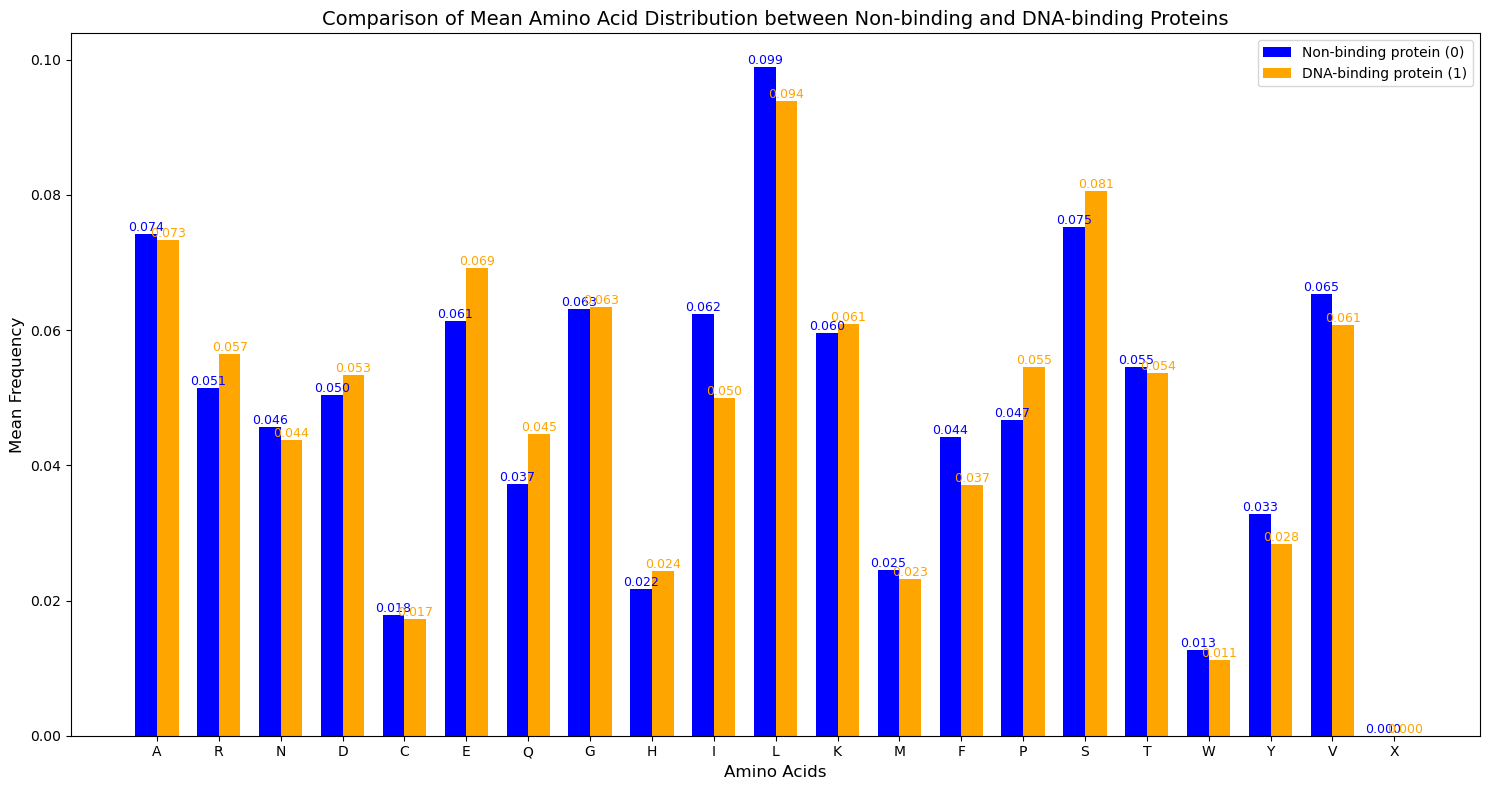

In [8]:
# Calculate mean frequencies for both label 0 (non-binding) and label 1 (binding) for each amino acid
mean_0 = [np.mean(df_training_0[aa].dropna()) for aa in standard_amino_acids]
mean_1 = [np.mean(df_training_1[aa].dropna()) for aa in standard_amino_acids]

# Create a new figure
plt.figure(figsize=(15, 8))

# Define the positions for the amino acids on the x-axis
x = np.arange(len(standard_amino_acids))

# Bar width
bar_width = 0.35

# Plot bars for label 0 (non-binding) and label 1 (binding)
bars_0 = plt.bar(x - bar_width/2, mean_0, bar_width, label='Non-binding protein (0)', color='blue')
bars_1 = plt.bar(x + bar_width/2, mean_1, bar_width, label='DNA-binding protein (1)', color='orange')

# Add the mean values on top of each bar
for bar in bars_0:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=9, color='blue')

for bar in bars_1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=9, color='orange')

# Set the x-axis ticks and labels (amino acids)
plt.xticks(x, standard_amino_acids)

# Set the labels and title
plt.xlabel('Amino Acids', fontsize=12)
plt.ylabel('Mean Frequency', fontsize=12)
plt.title('Comparison of Mean Amino Acid Distribution between Non-binding and DNA-binding Proteins', fontsize=14)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Compare Median frequency distribution between 2 classes

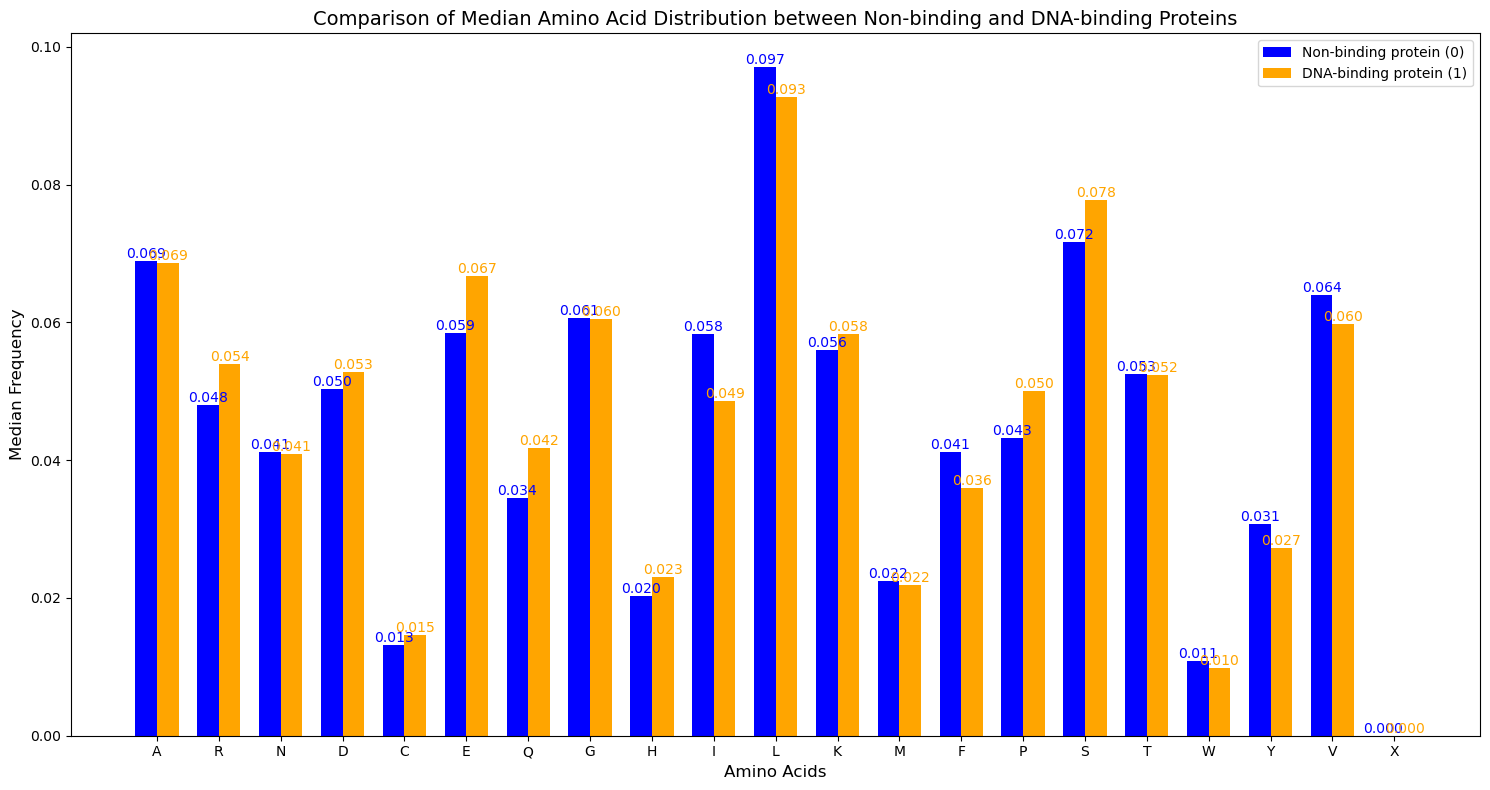

In [9]:
# Calculate median frequencies for both label 0 (non-binding) and label 1 (binding) for each amino acid
median_0 = [np.median(df_training_0[aa].dropna()) for aa in standard_amino_acids]
median_1 = [np.median(df_training_1[aa].dropna()) for aa in standard_amino_acids]

# Create a new figure
plt.figure(figsize=(15, 8))

# Define the positions for the amino acids on the x-axis
x = np.arange(len(standard_amino_acids))

# Bar width
bar_width = 0.35

# Plot bars for label 0 (non-binding) and label 1 (binding)
bars_0 = plt.bar(x - bar_width/2, median_0, bar_width, label='Non-binding protein (0)', color='blue')
bars_1 = plt.bar(x + bar_width/2, median_1, bar_width, label='DNA-binding protein (1)', color='orange')

# Add the median values on top of each bar
for bar in bars_0:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=10, color='blue')

for bar in bars_1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=10, color='orange')

# Set the x-axis ticks and labels (amino acids)
plt.xticks(x, standard_amino_acids)

# Set the labels and title
plt.xlabel('Amino Acids', fontsize=12)
plt.ylabel('Median Frequency', fontsize=12)
plt.title('Comparison of Median Amino Acid Distribution between Non-binding and DNA-binding Proteins', fontsize=14)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

From both median and mean amino acid distribution, we identify a is small difference ($\leq$ 0.002) between amino acid distribution of A, N, C, G, M, K, T, W, X. Hence, we deduce that the distribution of those amino acids do not affect the classification of a protein. Hence, we will remove those amino acids in our predictive model.

# Logistic Regression using Full Amino Acid Distribution 

In [10]:
# Iterate through each row in the DataFrame and compute the frequencies

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Select all columns from the 4th onwards as features
X_train = df_training.iloc[:, 3:].to_numpy()  # Assuming all amino acid frequencies are from the 4th column onwards

# Target labels
y_train = df_training['Label'].to_numpy()  # Ensure y is also a numpy array

X_test = df_testing.iloc[:,3:].to_numpy()
y_test = df_testing['Label'].to_numpy()

# Initialize the logistic regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test)




Text(0.5, 427.9555555555555, 'Predicted label')

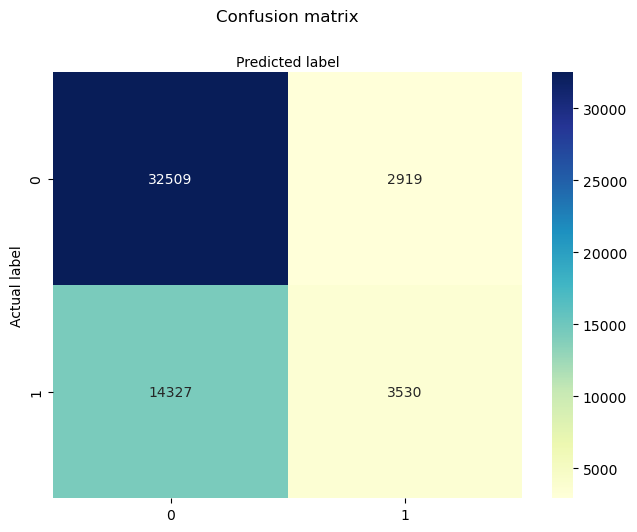

In [16]:
cnf_matrix = confusion_matrix(y_test, y_pred)
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


In [18]:
import statsmodels.api as sm
# Add a constant (intercept) to the model
X_train = sm.add_constant(X_train)  # This adds an intercept (bias term)

# Fit the logistic regression model
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# Print the summary, which includes p-values
print(result.summary())

         Current function value: 0.586565
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                53285
Model:                          Logit   Df Residuals:                    53263
Method:                           MLE   Df Model:                           21
Date:                Sat, 19 Oct 2024   Pseudo R-squ.:                 0.08025
Time:                        10:18:06   Log-Likelihood:                -31255.
converged:                      False   LL-Null:                       -33982.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        811.7424    922.815      0.880      0.379    -996.942    2620.427
x1          -816.9375    922.814     -0.885      0.376   -2625.62

/Users/annguyen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Logistic Regression using Selected Amino Acid Distribution

In [19]:
exclude_cols = ['A', 'N', 'C', 'G', 'M', 'K', 'T', 'W', 'X']
LR_selected = df_training.drop(columns=exclude_cols)
LR_selected.head()

,ID,Label,sequence,R,D,E,Q,H,I,L,F,P,S,Y,V
0,seq_0,1,MANILNLKHLLTLALILLALATKSSTSSSSSITRVKGIYWLENPFF...,0.026385,0.044855,0.029024,0.015831,0.010554,0.055409,0.100264,0.060686,0.058047,0.108179,0.036939,0.065963
1,seq_1,1,MVALLLFPMLLQLLSPTCAQTQKNITLGSTLAPQGPASSWLSPSGD...,0.039360,0.060271,0.045510,0.046740,0.013530,0.054121,0.100861,0.046740,0.046740,0.077491,0.035670,0.066421
2,seq_2,1,MDILQLAPTHLLAILLSSTSALFLITYLLRAGHRPSDLPNGPPTVP...,0.068441,0.058935,0.057034,0.045627,0.045627,0.060837,0.110266,0.039924,0.055133,0.077947,0.032319,0.047529
3,seq_3,1,MRLHQSPPRLLVCILSVLQVSAGLSSNCRCMPGDSCWPSLNDWARF...,0.038529,0.047285,0.031524,0.049037,0.024518,0.040280,0.096322,0.035026,0.056042,0.080560,0.035026,0.064799
4,seq_4,1,MAKIDVHHHFYPPAMRQALDRAGGDPSGWYIPPWTLELDQDITRQM...,0.052469,0.058642,0.046296,0.027778,0.033951,0.052469,0.108025,0.052469,0.080247,0.046296,0.033951,0.043210


In [32]:
selected_testing = df_testing.drop(columns=exclude_cols)

In [33]:
# Select all columns from the 4th onwards as features
X_train_selected = LR_selected.iloc[:, 3:].to_numpy()  # Assuming all amino acid frequencies are from the 4th column onwards

# Target labels
y_train_selected = LR_selected['Label'].to_numpy()  # Ensure y is also a numpy array

X_test = selected_testing.iloc[:,3:].to_numpy()
y_test = selected_testing['Label'].to_numpy()

# Initialize the logistic regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train_selected, y_train_selected)

# Predict on the test set
y_pred = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6736229708173032


In [34]:
# Add a constant (intercept) to the model
X_selected = sm.add_constant(X_train_selected)  # This adds an intercept (bias term)

# Fit the logistic regression model
logit_model = sm.Logit(y_train_selected, X_selected)
result = logit_model.fit()

# Print the summary, which includes p-values
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.590189
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                53285
Model:                          Logit   Df Residuals:                    53272
Method:                           MLE   Df Model:                           12
Date:                Sat, 19 Oct 2024   Pseudo R-squ.:                 0.07457
Time:                        10:24:56   Log-Likelihood:                -31448.
converged:                       True   LL-Null:                       -33982.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9726      0.136    -14.552      0.000      -2.238      -1.707
x1             1.1964      0.

# Naive Bayes using Amino Acid Distribution 

In [28]:
from sklearn.naive_bayes import GaussianNB
# Select all columns from the 4th onwards as features
X_train = df_training.iloc[:, 3:].to_numpy()  # Assuming all amino acid frequencies are from the 4th column onwards

# Target labels
y_train = df_training['Label'].to_numpy()  # Ensure y is also a numpy array

X_test = df_testing.iloc[:,3:].to_numpy()
y_test = df_testing['Label'].to_numpy()

# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Fit the model to the training data
gnb.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = gnb.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Print classification report (Precision, Recall, F1-score)
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.6848831753776861
Confusion Matrix:
[[24633 10795]
 [ 5996 11861]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.70      0.75     35428
           1       0.52      0.66      0.59     17857

    accuracy                           0.68     53285
   macro avg       0.66      0.68      0.67     53285
weighted avg       0.71      0.68      0.69     53285



## Naive Bayes using Selected Amino Acid Distribution

In [35]:
# Select all columns from the 4th onwards as features
X_train = LR_selected.iloc[:, 3:].to_numpy()  # Assuming all amino acid frequencies are from the 4th column onwards

# Target labels
y_train = LR_selected['Label'].to_numpy()  # Ensure y is also a numpy array

X_test = selected_testing.iloc[:,3:].to_numpy()
y_test = selected_testing['Label'].to_numpy()


# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Fit the model to the training data
gnb.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = gnb.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Print classification report (Precision, Recall, F1-score)
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.667148353195083
Confusion Matrix:
[[23297 12131]
 [ 5605 12252]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.66      0.72     35428
           1       0.50      0.69      0.58     17857

    accuracy                           0.67     53285
   macro avg       0.65      0.67      0.65     53285
weighted avg       0.70      0.67      0.68     53285



# KNN using Amino Acid Distribution

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# Select all columns from the 4th onwards as features
X_train = df_training.iloc[:, 3:].to_numpy()  # Assuming all amino acid frequencies are from the 4th column onwards

# Target labels
y_train = df_training['Label'].to_numpy()  # Ensure y is also a numpy array

X_test = df_testing.iloc[:,3:].to_numpy()
y_test = df_testing['Label'].to_numpy()

# Initialize the KNN classifier with a specific number of neighbors (e.g., k=5)
knn = KNeighborsClassifier(n_neighbors=250) #k = sqrt(N=50000)

# Fit the model on the training data
knn.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Print classification report (Precision, Recall, F1-score)
print('Classification Report:')
print(classification_report(y_test, y_pred))

## KNN using selected Amino Acid Distribution

In [ ]:
# Select all columns from the 4th onwards as features
X_train = LR_selected.iloc[:, 3:].to_numpy()  # Assuming all amino acid frequencies are from the 4th column onwards

# Target labels
y_train = LR_selected['Label'].to_numpy()  # Ensure y is also a numpy array

X_test = selected_testing.iloc[:,3:].to_numpy()
y_test = selected_testing['Label'].to_numpy()

# Fit the model on the training data
knn.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Print classification report (Precision, Recall, F1-score)
print('Classification Report:')
print(classification_report(y_test, y_pred))

# K-Mer Distribution

In [10]:
# Function to calculate k-mer frequencies
def kmer_frequencies(seq, k):
    # Generate all k-mers in the sequence
    kmers = [str(seq[i:i+k]) for i in range(len(seq) - k + 1)]
    return Counter(kmers)

sequences = df_training_1['sequence'].tolist()  # Assuming you have a 'sequence' column

k = 3  # Set k for 3-mer
overall_kmer_counts = Counter()

# Loop through each sequence and calculate 3-mer frequencies
for sequence in sequences:
    seq_obj = Seq(sequence)  # Convert to BioPython Seq object
    freqs = kmer_frequencies(seq_obj, k)
    overall_kmer_counts.update(freqs)  # Aggregate counts

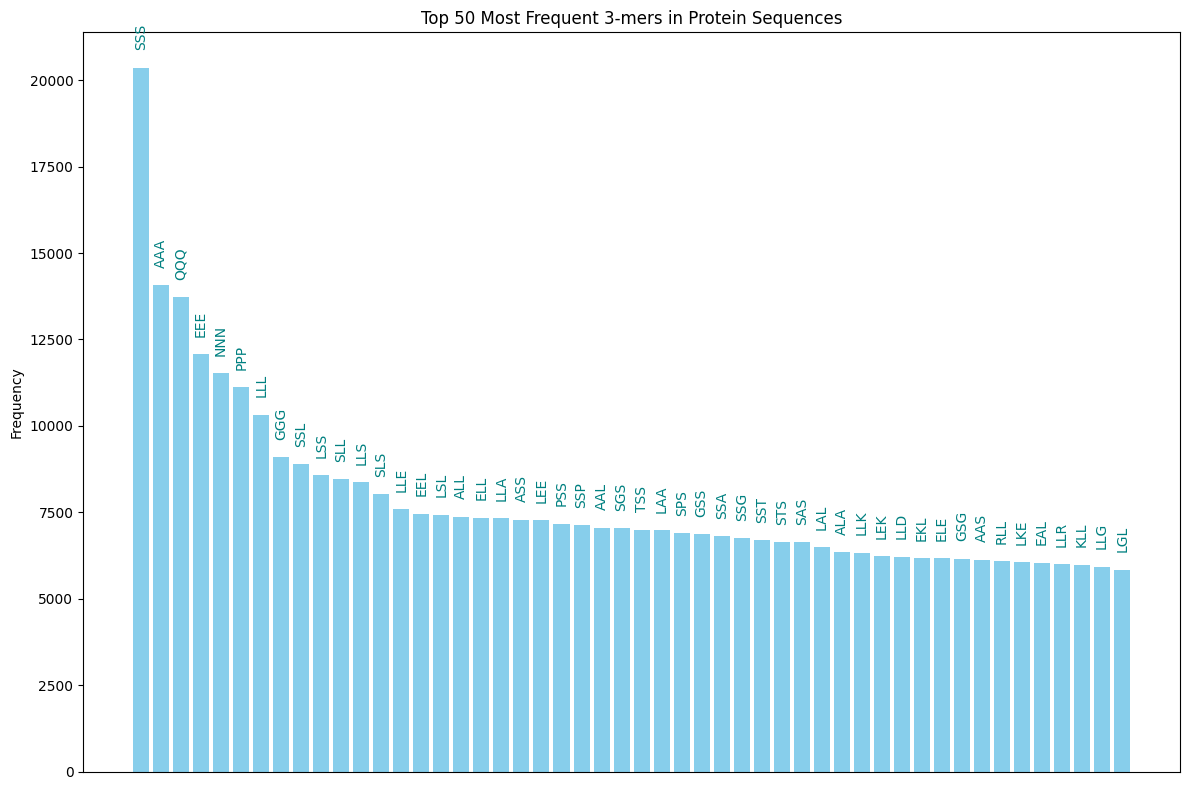

In [12]:
# Get the top 50 most frequent k-mers
top_50_kmers = overall_kmer_counts.most_common(50)

# Separate k-mers and their counts for plotting
kmer_list, count_list = zip(*top_50_kmers)

# Create the bar chart
plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(kmer_list)), count_list, color='skyblue')

# Annotate bars with the k-mer sequence (vertically)
for bar, kmer in zip(bars, kmer_list):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 500, kmer,
             ha='center', va='bottom', rotation='vertical', fontsize=10, color='teal')

# Add labels and title
plt.ylabel('Frequency')
plt.title('Top 50 Most Frequent 3-mers in Protein Sequences')
plt.xticks([])  # Hide x-axis labels as we are displaying them above bars
plt.tight_layout()

# Show the plot
plt.show()

## Create matrix for 3-mer

In [13]:
def generate_kmer_matrix_with_sklearn(sequences,k):
    # Step 1: Use CountVectorizer to count 3-mers (trigrams)
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(k, k))  # 3-mer (trigrams)
    
    # Step 2: Fit and transform the sequences into a matrix
    X = vectorizer.fit_transform(sequences)
    
    # Step 3: Get the list of 3-mer features (columns)
    feature_names = vectorizer.get_feature_names_out()
    
    # Step 4: Convert the matrix to a pandas DataFrame for easier visualization
    df = pd.DataFrame(X.toarray(), columns=feature_names)
    
    return df

In [ ]:
_3mer_matrix = generate_kmer_matrix_with_sklearn(df_training['sequence'],3)
_3mer_matrix

In [ ]:
_4mer_matrix = generate_kmer_matrix_with_sklearn(df_training['sequence'],4)
_4mer_matrix